In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
import seaborn as sns
from pathlib import Path
import warnings

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [4]:
data_dir = Path('./data/')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [5]:
algo_name = 'lgbcv'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = data_dir / f'{feature_name}.csv'
p_val_file = data_dir / f'{model_name}.val.csv'
p_tst_file = data_dir / f'{model_name}.tst.csv'
sub_file = data_dir / f'{model_name}.csv'

In [6]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 20)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
id,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,2.9444,1.1898,0.0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-2.6257,-3.3488,2.0462,0.7232,-15.0556
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.6931,1.2533,1.0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.7683,-0.8698,0.2767,0.1016,-0.3069
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0986,1.0225,0.0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.3649,-0.3905,0.1440,0.0257,-0.9014
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,1.6094,1.2054,0.0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-1.2000,-1.4395,0.5321,0.2395,-1.3906
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,2.6391,1.1939,0.0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-2.2436,-2.5579,0.9871,0.3144,-9.3609


In [7]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 19) (80000, 19)


In [8]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [28]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             n_estimators=3000,
                             num_leaves=256,
                             learning_rate=0.02,
                             min_child_samples=64,
                             subsample=.9,
                             subsample_freq=1,
                             colsample_bytree=.9,
                             random_state=17,
                             n_jobs=-1)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=100)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.956531
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.928587
[3]	valid_0's multi_logloss: 0.90208
[4]	valid_0's multi_logloss: 0.877013
[5]	valid_0's multi_logloss: 0.853816
[6]	valid_0's multi_logloss: 0.830967
[7]	valid_0's multi_logloss: 0.809158
[8]	valid_0's multi_logloss: 0.788348
[9]	valid_0's multi_logloss: 0.768408
[10]	valid_0's multi_logloss: 0.749646
[11]	valid_0's multi_logloss: 0.732466
[12]	valid_0's multi_logloss: 0.714795
[13]	valid_0's multi_logloss: 0.697851
[14]	valid_0's multi_logloss: 0.682076
[15]	valid_0's multi_logloss: 0.666936
[16]	valid_0's multi_logloss: 0.652408
[17]	valid_0's multi_logloss: 0.637884
[18]	valid_0's multi_logloss: 0.623945
[19]	valid_0's multi_logloss: 0.610406
[20]	valid_0's multi_logloss: 0.597434
[21]	valid_0's multi_logloss: 0.584893
[22]	valid_0's multi_logloss: 0.573974
[23]	valid_0's multi_logloss: 0.562657
[24]	valid_0's multi_loglo

[207]	valid_0's multi_logloss: 0.16774
[208]	valid_0's multi_logloss: 0.167602
[209]	valid_0's multi_logloss: 0.167477
[210]	valid_0's multi_logloss: 0.167329
[211]	valid_0's multi_logloss: 0.167191
[212]	valid_0's multi_logloss: 0.167062
[213]	valid_0's multi_logloss: 0.166918
[214]	valid_0's multi_logloss: 0.166806
[215]	valid_0's multi_logloss: 0.166677
[216]	valid_0's multi_logloss: 0.166559
[217]	valid_0's multi_logloss: 0.166425
[218]	valid_0's multi_logloss: 0.166309
[219]	valid_0's multi_logloss: 0.166177
[220]	valid_0's multi_logloss: 0.166063
[221]	valid_0's multi_logloss: 0.165959
[222]	valid_0's multi_logloss: 0.165849
[223]	valid_0's multi_logloss: 0.165735
[224]	valid_0's multi_logloss: 0.165629
[225]	valid_0's multi_logloss: 0.165514
[226]	valid_0's multi_logloss: 0.165412
[227]	valid_0's multi_logloss: 0.165298
[228]	valid_0's multi_logloss: 0.165199
[229]	valid_0's multi_logloss: 0.165117
[230]	valid_0's multi_logloss: 0.165011
[231]	valid_0's multi_logloss: 0.164917
[

[414]	valid_0's multi_logloss: 0.159039
[415]	valid_0's multi_logloss: 0.159021
[416]	valid_0's multi_logloss: 0.159013
[417]	valid_0's multi_logloss: 0.159008
[418]	valid_0's multi_logloss: 0.159006
[419]	valid_0's multi_logloss: 0.158997
[420]	valid_0's multi_logloss: 0.158988
[421]	valid_0's multi_logloss: 0.158987
[422]	valid_0's multi_logloss: 0.158975
[423]	valid_0's multi_logloss: 0.158962
[424]	valid_0's multi_logloss: 0.158955
[425]	valid_0's multi_logloss: 0.158947
[426]	valid_0's multi_logloss: 0.158937
[427]	valid_0's multi_logloss: 0.158931
[428]	valid_0's multi_logloss: 0.158931
[429]	valid_0's multi_logloss: 0.158925
[430]	valid_0's multi_logloss: 0.15893
[431]	valid_0's multi_logloss: 0.158932
[432]	valid_0's multi_logloss: 0.15893
[433]	valid_0's multi_logloss: 0.158922
[434]	valid_0's multi_logloss: 0.158919
[435]	valid_0's multi_logloss: 0.158918
[436]	valid_0's multi_logloss: 0.158915
[437]	valid_0's multi_logloss: 0.158911
[438]	valid_0's multi_logloss: 0.158897
[4

[8]	valid_0's multi_logloss: 0.788942
[9]	valid_0's multi_logloss: 0.769046
[10]	valid_0's multi_logloss: 0.750212
[11]	valid_0's multi_logloss: 0.733075
[12]	valid_0's multi_logloss: 0.715513
[13]	valid_0's multi_logloss: 0.698641
[14]	valid_0's multi_logloss: 0.682983
[15]	valid_0's multi_logloss: 0.667854
[16]	valid_0's multi_logloss: 0.653367
[17]	valid_0's multi_logloss: 0.638889
[18]	valid_0's multi_logloss: 0.624951
[19]	valid_0's multi_logloss: 0.611495
[20]	valid_0's multi_logloss: 0.59851
[21]	valid_0's multi_logloss: 0.585985
[22]	valid_0's multi_logloss: 0.575077
[23]	valid_0's multi_logloss: 0.563764
[24]	valid_0's multi_logloss: 0.552422
[25]	valid_0's multi_logloss: 0.541933
[26]	valid_0's multi_logloss: 0.531327
[27]	valid_0's multi_logloss: 0.521361
[28]	valid_0's multi_logloss: 0.511569
[29]	valid_0's multi_logloss: 0.50199
[30]	valid_0's multi_logloss: 0.492712
[31]	valid_0's multi_logloss: 0.4843
[32]	valid_0's multi_logloss: 0.4756
[33]	valid_0's multi_logloss: 0.4

[217]	valid_0's multi_logloss: 0.167114
[218]	valid_0's multi_logloss: 0.16699
[219]	valid_0's multi_logloss: 0.166867
[220]	valid_0's multi_logloss: 0.166755
[221]	valid_0's multi_logloss: 0.166663
[222]	valid_0's multi_logloss: 0.166545
[223]	valid_0's multi_logloss: 0.166441
[224]	valid_0's multi_logloss: 0.166319
[225]	valid_0's multi_logloss: 0.166206
[226]	valid_0's multi_logloss: 0.166102
[227]	valid_0's multi_logloss: 0.166003
[228]	valid_0's multi_logloss: 0.165889
[229]	valid_0's multi_logloss: 0.165793
[230]	valid_0's multi_logloss: 0.165687
[231]	valid_0's multi_logloss: 0.165598
[232]	valid_0's multi_logloss: 0.165507
[233]	valid_0's multi_logloss: 0.165402
[234]	valid_0's multi_logloss: 0.165307
[235]	valid_0's multi_logloss: 0.165213
[236]	valid_0's multi_logloss: 0.16515
[237]	valid_0's multi_logloss: 0.165055
[238]	valid_0's multi_logloss: 0.164961
[239]	valid_0's multi_logloss: 0.164881
[240]	valid_0's multi_logloss: 0.164805
[241]	valid_0's multi_logloss: 0.164722
[2

[424]	valid_0's multi_logloss: 0.159622
[425]	valid_0's multi_logloss: 0.159617
[426]	valid_0's multi_logloss: 0.159604
[427]	valid_0's multi_logloss: 0.159601
[428]	valid_0's multi_logloss: 0.159603
[429]	valid_0's multi_logloss: 0.159602
[430]	valid_0's multi_logloss: 0.159597
[431]	valid_0's multi_logloss: 0.159594
[432]	valid_0's multi_logloss: 0.159588
[433]	valid_0's multi_logloss: 0.159576
[434]	valid_0's multi_logloss: 0.159571
[435]	valid_0's multi_logloss: 0.159556
[436]	valid_0's multi_logloss: 0.159546
[437]	valid_0's multi_logloss: 0.159536
[438]	valid_0's multi_logloss: 0.159521
[439]	valid_0's multi_logloss: 0.159509
[440]	valid_0's multi_logloss: 0.159506
[441]	valid_0's multi_logloss: 0.159503
[442]	valid_0's multi_logloss: 0.159494
[443]	valid_0's multi_logloss: 0.159487
[444]	valid_0's multi_logloss: 0.159486
[445]	valid_0's multi_logloss: 0.159488
[446]	valid_0's multi_logloss: 0.159491
[447]	valid_0's multi_logloss: 0.159482
[448]	valid_0's multi_logloss: 0.159488


training model for CV #3
[1]	valid_0's multi_logloss: 0.956588
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.92875
[3]	valid_0's multi_logloss: 0.902366
[4]	valid_0's multi_logloss: 0.877404
[5]	valid_0's multi_logloss: 0.854292
[6]	valid_0's multi_logloss: 0.831473
[7]	valid_0's multi_logloss: 0.809745
[8]	valid_0's multi_logloss: 0.789
[9]	valid_0's multi_logloss: 0.769144
[10]	valid_0's multi_logloss: 0.750435
[11]	valid_0's multi_logloss: 0.733307
[12]	valid_0's multi_logloss: 0.715726
[13]	valid_0's multi_logloss: 0.698811
[14]	valid_0's multi_logloss: 0.683103
[15]	valid_0's multi_logloss: 0.667971
[16]	valid_0's multi_logloss: 0.653526
[17]	valid_0's multi_logloss: 0.638993
[18]	valid_0's multi_logloss: 0.625049
[19]	valid_0's multi_logloss: 0.61157
[20]	valid_0's multi_logloss: 0.598552
[21]	valid_0's multi_logloss: 0.586056
[22]	valid_0's multi_logloss: 0.575191
[23]	valid_0's multi_logloss: 0.563851
[24]	valid_0's multi_logloss: 

[209]	valid_0's multi_logloss: 0.168938
[210]	valid_0's multi_logloss: 0.168772
[211]	valid_0's multi_logloss: 0.168623
[212]	valid_0's multi_logloss: 0.168486
[213]	valid_0's multi_logloss: 0.168359
[214]	valid_0's multi_logloss: 0.168228
[215]	valid_0's multi_logloss: 0.16811
[216]	valid_0's multi_logloss: 0.167981
[217]	valid_0's multi_logloss: 0.167871
[218]	valid_0's multi_logloss: 0.167762
[219]	valid_0's multi_logloss: 0.16763
[220]	valid_0's multi_logloss: 0.167503
[221]	valid_0's multi_logloss: 0.167401
[222]	valid_0's multi_logloss: 0.167283
[223]	valid_0's multi_logloss: 0.167166
[224]	valid_0's multi_logloss: 0.167058
[225]	valid_0's multi_logloss: 0.166947
[226]	valid_0's multi_logloss: 0.166841
[227]	valid_0's multi_logloss: 0.166742
[228]	valid_0's multi_logloss: 0.166641
[229]	valid_0's multi_logloss: 0.166563
[230]	valid_0's multi_logloss: 0.166459
[231]	valid_0's multi_logloss: 0.166366
[232]	valid_0's multi_logloss: 0.166287
[233]	valid_0's multi_logloss: 0.166194
[2

[417]	valid_0's multi_logloss: 0.160396
[418]	valid_0's multi_logloss: 0.160386
[419]	valid_0's multi_logloss: 0.160398
[420]	valid_0's multi_logloss: 0.160392
[421]	valid_0's multi_logloss: 0.160393
[422]	valid_0's multi_logloss: 0.160384
[423]	valid_0's multi_logloss: 0.160381
[424]	valid_0's multi_logloss: 0.160373
[425]	valid_0's multi_logloss: 0.160366
[426]	valid_0's multi_logloss: 0.160372
[427]	valid_0's multi_logloss: 0.160383
[428]	valid_0's multi_logloss: 0.160382
[429]	valid_0's multi_logloss: 0.160378
[430]	valid_0's multi_logloss: 0.160381
[431]	valid_0's multi_logloss: 0.160364
[432]	valid_0's multi_logloss: 0.160361
[433]	valid_0's multi_logloss: 0.160361
[434]	valid_0's multi_logloss: 0.160356
[435]	valid_0's multi_logloss: 0.160346
[436]	valid_0's multi_logloss: 0.16035
[437]	valid_0's multi_logloss: 0.160352
[438]	valid_0's multi_logloss: 0.160354
[439]	valid_0's multi_logloss: 0.160356
[440]	valid_0's multi_logloss: 0.160354
[441]	valid_0's multi_logloss: 0.160353
[

[35]	valid_0's multi_logloss: 0.450939
[36]	valid_0's multi_logloss: 0.443292
[37]	valid_0's multi_logloss: 0.43604
[38]	valid_0's multi_logloss: 0.428816
[39]	valid_0's multi_logloss: 0.421834
[40]	valid_0's multi_logloss: 0.415098
[41]	valid_0's multi_logloss: 0.408886
[42]	valid_0's multi_logloss: 0.402465
[43]	valid_0's multi_logloss: 0.3974
[44]	valid_0's multi_logloss: 0.391415
[45]	valid_0's multi_logloss: 0.385581
[46]	valid_0's multi_logloss: 0.379873
[47]	valid_0's multi_logloss: 0.374363
[48]	valid_0's multi_logloss: 0.369068
[49]	valid_0's multi_logloss: 0.363845
[50]	valid_0's multi_logloss: 0.358831
[51]	valid_0's multi_logloss: 0.354081
[52]	valid_0's multi_logloss: 0.349284
[53]	valid_0's multi_logloss: 0.344687
[54]	valid_0's multi_logloss: 0.340149
[55]	valid_0's multi_logloss: 0.335758
[56]	valid_0's multi_logloss: 0.331459
[57]	valid_0's multi_logloss: 0.327534
[58]	valid_0's multi_logloss: 0.323724
[59]	valid_0's multi_logloss: 0.319744
[60]	valid_0's multi_logloss

[243]	valid_0's multi_logloss: 0.165254
[244]	valid_0's multi_logloss: 0.165175
[245]	valid_0's multi_logloss: 0.165108
[246]	valid_0's multi_logloss: 0.165026
[247]	valid_0's multi_logloss: 0.164958
[248]	valid_0's multi_logloss: 0.164884
[249]	valid_0's multi_logloss: 0.164815
[250]	valid_0's multi_logloss: 0.164737
[251]	valid_0's multi_logloss: 0.164668
[252]	valid_0's multi_logloss: 0.164597
[253]	valid_0's multi_logloss: 0.164518
[254]	valid_0's multi_logloss: 0.16446
[255]	valid_0's multi_logloss: 0.164377
[256]	valid_0's multi_logloss: 0.164321
[257]	valid_0's multi_logloss: 0.164256
[258]	valid_0's multi_logloss: 0.164203
[259]	valid_0's multi_logloss: 0.164141
[260]	valid_0's multi_logloss: 0.164085
[261]	valid_0's multi_logloss: 0.16402
[262]	valid_0's multi_logloss: 0.163957
[263]	valid_0's multi_logloss: 0.163898
[264]	valid_0's multi_logloss: 0.163842
[265]	valid_0's multi_logloss: 0.163795
[266]	valid_0's multi_logloss: 0.163732
[267]	valid_0's multi_logloss: 0.163675
[2

[451]	valid_0's multi_logloss: 0.160266
[452]	valid_0's multi_logloss: 0.160265
[453]	valid_0's multi_logloss: 0.160261
[454]	valid_0's multi_logloss: 0.160268
[455]	valid_0's multi_logloss: 0.160265
[456]	valid_0's multi_logloss: 0.160262
[457]	valid_0's multi_logloss: 0.160271
[458]	valid_0's multi_logloss: 0.160274
[459]	valid_0's multi_logloss: 0.160269
[460]	valid_0's multi_logloss: 0.160266
[461]	valid_0's multi_logloss: 0.160259
[462]	valid_0's multi_logloss: 0.160264
[463]	valid_0's multi_logloss: 0.160265
[464]	valid_0's multi_logloss: 0.160263
[465]	valid_0's multi_logloss: 0.160269
[466]	valid_0's multi_logloss: 0.160267
[467]	valid_0's multi_logloss: 0.16026
[468]	valid_0's multi_logloss: 0.160265
[469]	valid_0's multi_logloss: 0.160265
[470]	valid_0's multi_logloss: 0.160267
[471]	valid_0's multi_logloss: 0.160262
[472]	valid_0's multi_logloss: 0.160269
[473]	valid_0's multi_logloss: 0.16027
[474]	valid_0's multi_logloss: 0.160276
[475]	valid_0's multi_logloss: 0.160277
[4

[66]	valid_0's multi_logloss: 0.294956
[67]	valid_0's multi_logloss: 0.291803
[68]	valid_0's multi_logloss: 0.288675
[69]	valid_0's multi_logloss: 0.285695
[70]	valid_0's multi_logloss: 0.283014
[71]	valid_0's multi_logloss: 0.280092
[72]	valid_0's multi_logloss: 0.277262
[73]	valid_0's multi_logloss: 0.274581
[74]	valid_0's multi_logloss: 0.271923
[75]	valid_0's multi_logloss: 0.269341
[76]	valid_0's multi_logloss: 0.266818
[77]	valid_0's multi_logloss: 0.26454
[78]	valid_0's multi_logloss: 0.262141
[79]	valid_0's multi_logloss: 0.259806
[80]	valid_0's multi_logloss: 0.257497
[81]	valid_0's multi_logloss: 0.255276
[82]	valid_0's multi_logloss: 0.253072
[83]	valid_0's multi_logloss: 0.250965
[84]	valid_0's multi_logloss: 0.248972
[85]	valid_0's multi_logloss: 0.247101
[86]	valid_0's multi_logloss: 0.245245
[87]	valid_0's multi_logloss: 0.243369
[88]	valid_0's multi_logloss: 0.241686
[89]	valid_0's multi_logloss: 0.240008
[90]	valid_0's multi_logloss: 0.238214
[91]	valid_0's multi_loglo

[273]	valid_0's multi_logloss: 0.162207
[274]	valid_0's multi_logloss: 0.162163
[275]	valid_0's multi_logloss: 0.162105
[276]	valid_0's multi_logloss: 0.162056
[277]	valid_0's multi_logloss: 0.162011
[278]	valid_0's multi_logloss: 0.161966
[279]	valid_0's multi_logloss: 0.16193
[280]	valid_0's multi_logloss: 0.161893
[281]	valid_0's multi_logloss: 0.161854
[282]	valid_0's multi_logloss: 0.161809
[283]	valid_0's multi_logloss: 0.161755
[284]	valid_0's multi_logloss: 0.161712
[285]	valid_0's multi_logloss: 0.161671
[286]	valid_0's multi_logloss: 0.161623
[287]	valid_0's multi_logloss: 0.161586
[288]	valid_0's multi_logloss: 0.161556
[289]	valid_0's multi_logloss: 0.161517
[290]	valid_0's multi_logloss: 0.161472
[291]	valid_0's multi_logloss: 0.161443
[292]	valid_0's multi_logloss: 0.161401
[293]	valid_0's multi_logloss: 0.161365
[294]	valid_0's multi_logloss: 0.161341
[295]	valid_0's multi_logloss: 0.161303
[296]	valid_0's multi_logloss: 0.161267
[297]	valid_0's multi_logloss: 0.16124
[2

[480]	valid_0's multi_logloss: 0.159182
[481]	valid_0's multi_logloss: 0.159184
[482]	valid_0's multi_logloss: 0.159174
[483]	valid_0's multi_logloss: 0.159178
[484]	valid_0's multi_logloss: 0.159175
[485]	valid_0's multi_logloss: 0.159172
[486]	valid_0's multi_logloss: 0.159179
[487]	valid_0's multi_logloss: 0.159179
[488]	valid_0's multi_logloss: 0.159183
[489]	valid_0's multi_logloss: 0.15919
[490]	valid_0's multi_logloss: 0.159196
[491]	valid_0's multi_logloss: 0.159195
[492]	valid_0's multi_logloss: 0.159202
[493]	valid_0's multi_logloss: 0.159202
[494]	valid_0's multi_logloss: 0.159202
[495]	valid_0's multi_logloss: 0.159199
[496]	valid_0's multi_logloss: 0.159203
[497]	valid_0's multi_logloss: 0.159209
[498]	valid_0's multi_logloss: 0.15921
[499]	valid_0's multi_logloss: 0.159203
[500]	valid_0's multi_logloss: 0.159208
[501]	valid_0's multi_logloss: 0.159216
[502]	valid_0's multi_logloss: 0.15921
[503]	valid_0's multi_logloss: 0.159214
[504]	valid_0's multi_logloss: 0.15923
[505

In [37]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.3406%


In [38]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [39]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

<AxesSubplot:ylabel='feature'>

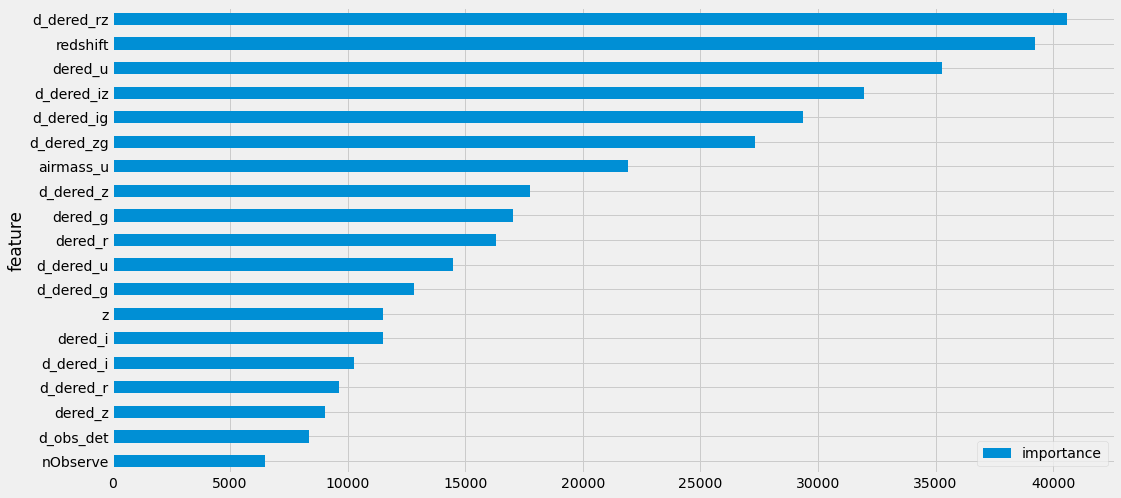

In [40]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [41]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [42]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [43]:
sub[target_col].value_counts()

2    40884
0    29973
1     9143
Name: class, dtype: int64

In [44]:
sub.to_csv(sub_file)